In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import c, k_B, M_sun, G, m_p, sigma_sb, m_p
import astropy.units as u
from scipy.integrate import solve_ivp
from scipy.sparse import csr_matrix
from scipy.integrate import LSODA
import numpy as np
import numba
import sys

sys.path.append('../Numerical_methods')
from matrix_calculator import A_matrix
from scheme_calculator import forward_backward
from bachelor_funcs import Σ_initial, r_array, get_1_dev_irr, first_dev_matrix, r_ghost, sA_ghost, A_ghost

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

### Equation 10 from Suzuki

$$  \frac{\partial\Sigma}{\partial t} - \frac{1}{r}\frac{\partial}{\partial r}\left[
    \frac{2}{r\Omega}\left\{
    \frac{\partial}{\partial r}\left(
    r^2\Sigma\alpha_{r\phi}c_s^2
    \right)
    + r^2\alpha_{\phi z}(\rho c_s^2)_{\textrm{mid}}
    \right\}\right]
    + C_{\textrm{w}}(\rho c_s)_{\textrm{mid}}
    \;=\;0$$

$$
\Omega\approx\Omega_K=\sqrt{\frac{GM_*}{r^3}}
$$    

$$
c_s^2=\frac{k_BT}{\mu m_H}
$$

#### Neglecting disc wind and torque:
$$  \frac{\partial\Sigma}{\partial t} - \frac{1}{r}\frac{\partial}{\partial r}\left[
    \frac{2}{r\Omega}\left\{
    \frac{\partial}{\partial r}\left(
    r^2\Sigma\alpha_{r\phi}c_s^2
    \right)
    \right\}\right]
    
    \;=\;0$$

#### From B.10:
$$\sigma_\textrm{SB}T^4=\frac{3}{4}\Omega\Sigma\bar{\alpha_{r\phi}}c_s^2$$

$$\Rightarrow \quad c_s^6\;=\;\frac{1}{\sigma_\textrm{SB}}
\left(\frac{\mu m_{H}}{K_B}\right)^{-4}
\frac{3}{4}\Omega\Sigma \bar{\alpha_{r\phi}}
$$

In [3]:
μ = 2.34    #(Hayashi 1981)

In [4]:
def Omega_kep(r):
    return np.sqrt((G * M_sun) / r**3)


def c_s(Ω,  Σ, α_rφ = 8e-3):
    return ((sigma_sb**(-1) * (μ * m_p / k_B)**(-4) * 3/4 * Ω * Σ * α_rφ)**(1/6)).to('m/s')

In [5]:
r = r_array * u.au
c_s(Omega_kep(r), Σ_initial(r))

<Quantity [9.06354973e+03, 8.84509427e+03, 8.63686089e+03, ...,
           6.96826393e-24, 6.77572184e-24, 6.58845461e-24] m / s>

### Imposing the boundary condition $\frac{\partial}{\partial r}(\Sigma r^{3/2})=0$

$$\frac{\partial}{\partial r}(\Sigma r^{3/2})=0$$
$$\Rightarrow\frac{\partial}{\partial r}(\Sigma)\cdot r^{3/2}\;+\;\frac{3}{2}\Sigma r^{1/2}=0$$
$$\Sigma r^{2}=-\frac{2}{3}\;r^{3}\;\frac{\partial}{\partial r}\Sigma$$


In [6]:
α_rφ = 8e-3

def one_alpha(Σ):
    
    inner_1 = Σ * r**(2)
    #inner_1[0] = boundary[0]
    #inner_1[-1] = boundary[-1]

    inner_2 = α_rφ * c_s(Omega_kep(r), Σ)**2

    inner_dev = get_1_dev_irr(inner_1 * inner_2)
    print(inner_dev.unit)
    
    outer_dev = get_1_dev_irr(2 / (r *Omega_kep(r)) * inner_dev)
    print((r**(-1)*outer_dev).unit)

    #outer_dev[0] = 0
    #outer_dev[-1] = 0

    return ((r**(-1) * outer_dev * u.au**(-2)).to('mg/(yr * cm^2)'))

In [7]:
one_alpha(Σ_initial(r))

AU2 g m2 / (cm2 s2)
AU(3/2) g m(1/2) / (cm2 s)


<Quantity [7.78116936e+008, 6.81609487e+008, 5.92828689e+008, ...,
           3.84957331e-197, 3.05367187e-197, 2.32118601e-197] mg / (cm2 yr)>

In [8]:
α_rφ = 8e-3
sA_ghost, np.shape(A_ghost), 

(<4048x4048 sparse matrix of type '<class 'numpy.float64'>'
 	with 12138 stored elements in Compressed Sparse Row format>,
 (4048, 4048))

In [9]:
A_ghost[-2,-4:]

array([-0.10000227,  0.        ,  0.10000227,  0.        ])

In [10]:
def one_alpha2(t, Σ):
    Σ = Σ *  u.g * u.cm**-2
    r_ghost_au = r_ghost * u.au
    r_au = r_array * u.au
    Σ = Σ_initial(r_au)

    inner = r_au**2 * Σ * α_rφ * c_s(Omega_kep(r_au), Σ)**2
    inner_unit = inner.unit

    ghost_1 = np.array([inner[1].value])
    ghost_2 = np.array([inner[-2].value])

    inner_ghost = np.concatenate((ghost_1, np.array(inner), ghost_2)) * inner_unit

    outer_ghost = 2 / (r_ghost_au * Omega_kep(r_ghost_au)) * (A_ghost @ inner_ghost)
    
    sec_dev = 1/r_ghost_au * (A_ghost @ outer_ghost)

    df_dt = (sec_dev[1: -1] * u.au**(-2)).to('mg/(yr * cm^2)')

    return df_dt.value 

In [11]:
#def one_alpha3(t, Σ):
Σ = Σ_initial(r_array * u.au).value
Σ = Σ *  u.g * u.cm**-2
r_ghost_au = r_ghost * u.au
r_au = r_array * u.au


#Calculating inner function
inner = r_au**2 * Σ * α_rφ * c_s(Omega_kep(r_au), Σ)**2
inner_unit = inner.unit

# Making ghost point to set derivative to zero for boundary
ghost_1 = np.array([inner[1].value])
ghost_2 = np.array([inner[-2].value])
inner_ghost = np.concatenate((ghost_1, np.array(inner), ghost_2)) * inner_unit

outer_ghost = 2 / (r_ghost_au * Omega_kep(r_ghost_au)) * (A_ghost @ inner_ghost)

sec_dev = 1/r_ghost_au * (A_ghost @ outer_ghost)


df_dt = (sec_dev[1: -1] * u.au**(-2)).to('mg/(yr * cm^2)')

df_dt[:10]

    #return df_dt

<Quantity [-7.70162209e+09, -6.95645239e+09,  5.95512659e+08,
            5.17785330e+08,  4.51625741e+08,  3.95109638e+08,
            3.46665176e+08,  3.05002698e+08,  2.69059597e+08,
            2.37956792e+08] mg / (cm2 yr)>

#### "one_alphaX" return in terms of:
$$\left[\frac{g}{cm^2}\frac{1}{kyr}\right]$$

In [12]:
# Default values for tolerance:
# rtol: 1e-3, 1e-6
# atol: 1e-6, 1e-4 

times = np.arange(0, 10001, 1)
# This termimal takes just about 3min to run
sol = solve_ivp(one_alpha2, [times[0], times[-1]], y0 = Σ_initial(r).value, method = 'LSODA', t_eval = times, atol=1e-4, rtol=1e-6)

[Text(0, 0.5, 'Δr [AU]')]

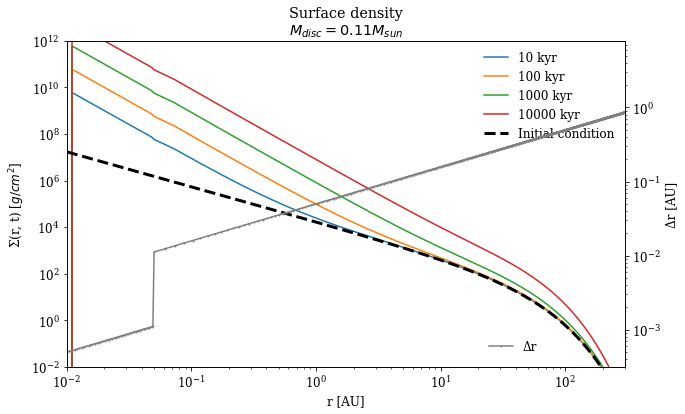

In [15]:
fig, axs = plt.subplots(figsize = (10,6))

for i in [1e1, 1e2, 1e3, 1e4]:
    axs.loglog(r_array, sol.y[:, sol.t == i], label = f'{i:1.0f} kyr')


axs.plot(r_array, Σ_initial(r), ls='--', lw=3, c='black', label = 'Initial condition')

axs.set(xlabel = 'r [AU]', ylabel = 'Σ(r, t) [$g/cm^2$]', 
title = 'Surface density\n$M_{disc}=0.11M_{sun}$', yscale = 'log', xscale = 'log', ylim = (1e-2,1e12), xlim = (0.01, 300))
plt.legend(frameon=False, loc='upper right' )

axs2 = axs.twinx()

axs2.loglog(r_array[:-1], np.diff(r_array), ls = '-', marker = 'o', c = 'grey', label='Δr', ms=1)
axs2.legend(loc='lower center', frameon=False, bbox_to_anchor=(0.8,0.01))
axs2.set(ylabel='Δr [AU]')

(0.0, 100.0)

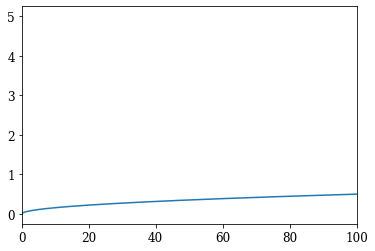

In [14]:
plt.plot(r_array[:-1], np.diff(r_array))
plt.xlim(0,100)